-----------------------------------------------------------------------
This demo script reads in a matrix of pixel from C++ and applies image
compression using cosine transformations.
The end result shows the transformed matrix with the same memory address
as the original.
-----------------------------------------------------------------------

1) Read in pixel from the cpp2np module. The original array is 8x8 array of int16_t:

Pixel array (uint8):
<class 'numpy.ndarray'>
{'data': 57763552, 'ndim': 2, 'shape': (8, 8), 'typestr': '|u1'}
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

[[237  40  48  54  42  31   6  17]
 [ 38  40  36  33  37  43  31  13]
 [ 18 245 251 249 246  17  34  16]
 [229 161 149 152 165 238  18  31]
 [234 176   2  31 129 156 244  36]
 [222 198  25  79 142 157 249  22]
 [239 148 127 146 127 157   4   7]
 [ 35   1 210 194 196 234  11  31]]
Created pixel matrix with pointer: 57763552


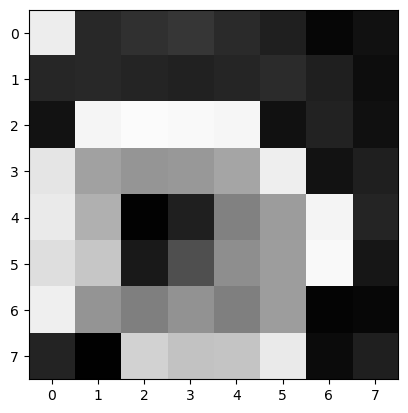



3) Compress image with 2D cosine transformation:

{'data': 64437520, 'ndim': 2, 'shape': (8, 8), 'typestr': '<f8'}
[[219.70812855  62.04034663  34.93633371  51.65066256  41.87114992
   26.32127632  -9.69570498   2.97334593]
 [ 41.83036081  35.90364124  35.75415831  32.72337619  54.31574816
   62.03330814  24.06744376   4.67488919]
 [ 39.31319568 250.05338715 220.79688152 288.4000399  208.47495092
    1.8571137   58.16309482  24.16061743]
 [233.82278741 125.24354899 164.15681449 129.70684406 195.04259707
  232.62146404  45.33351153  42.92880287]
 [199.07163497 196.55801218 -12.51571507  42.53729942 119.77483444
  144.43423629 231.58177963  18.19379976]
 [251.54603442 186.32038206  17.13320139  83.14726897 155.18244461
  181.5305159  228.69710837  33.71316976]
 [260.9974603  127.00111565 151.38271858 117.17355948 128.99542437
  143.47809357   3.82783585   3.35145981]
 [ -2.61211692  26.3594882  226.98315947 186.39653415 206.18237735
  226.98350368   6.6579449   40.75131845]]


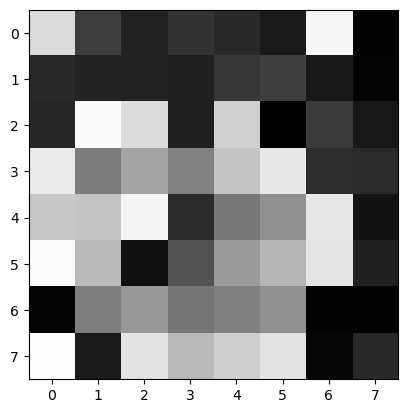



4) Transform result back to uint8 and assign changes to original memory area:

pixel matrix (uint8):
pointer address: 57763552
[ 219   62   34   51   41   26  247    2]
[  41   35   35   32   54   62   24    4]
[  39  250  220   32  208    1   58   24]
[ 233  125  164  129  195  232   45   42]
[ 199  196  244   42  119  144  231   18]
[ 251  186   17   83  155  181  228   33]
[   4  127  151  117  128  143    3    3]
[ 254   26  226  186  206  226    6   40]
[  41   35   35   32   54   62   24    4]
[  39  250  220   32  208    1   58   24]
[ 233  125  164  129  195  232   45   42]
[ 199  196  244   42  119  144  231   18]
[ 251  186   17   83  155  181  228   33]
[   4  127  151  117  128  143    3    3]
[ 254   26  226  186  206  226    6   40]


In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.fftpack as sfft
import cpp2np as c2n

                
def quant1(V8,p):
    V8 = V8.astype('int16') - 128
    A = sfft.dctn(V8, norm='ortho')
    Q = p*np.array([[8,16,24,32,40,48,56,64],[16,24,32,40,48,56,64,72],[24,32,40,48,56,64,72,80],[32,40,48,56,64,72,80,88],[40,48,56,64,72,80,88,96],[48,56,64,72,80,88,96,104],[56,64,72,80,88,96,104,112],[64,72,80,88,96,104,112,120]],dtype='uint8')
    AQ = np.rint(A/Q)
    VQ = AQ*Q
    Alow = sfft.idctn(VQ,norm='ortho')
    Alow = Alow + 128
    return Alow

print("-----------------------------------------------------------------------")
print("This demo script reads in a matrix of pixel from C++ and applies image\n" +
      "compression using cosine transformations.")
print("The end result shows the transformed matrix with the same memory address\nas the original.")
print("-----------------------------------------------------------------------")

# read in pixel from c++ array
print("\n1) Read in pixel from the cpp2np module. The original array is 8x8 array of int16_t:\n")

ptr, shape = c2n.c_arr_pixel()
pixel = c2n.wrap(ptr, shape, dtype=np.dtype('uint8'))

print('Pixel array (uint8):')
print(type(pixel))
print(c2n.descr(pixel))
print(pixel.flags)
print(pixel)

img = Image.fromarray(pixel).convert('LA')
plt.figure(1)
plt.imshow(img)
plt.show()


# apply cosine transformation for compression
print("\n\n3) Compress image with 2D cosine transformation:\n")

A = quant1(pixel, 1)
print(c2n.descr(A))
print(A)

img_compressed = Image.fromarray(A.astype('int8')).convert('LA')
plt.figure(2)
plt.imshow(img_compressed)
plt.show()

# assign changes back to original memory area in c++
print("\n\n4) Transform result back to uint8 and assign changes to original memory area:\n")

np.place(pixel, np.ones(shape), A.astype('uint8').tolist())
print('pixel matrix (uint8):')
c2n.print_testarr(ptr)

# free memory
res = c2n.free(ptr)